<a href="https://colab.research.google.com/github/ML4SCI/ML4SCIHackathon/blob/main/ParticleImagesChallenge/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><h1>ML4SCI Hackathon 2021</h1>
<h2>Problem Statement : </h2>

*   One of the important aspects of searches for new physics at the Large Hadron Collider (LHC) involves the classification of various High-Energy Particles in collision events
*   The goal of this challenge is to implement Vision Transformers on the dataset which will classify electron and photon particles as accurately as possible based on the detector images provided in the dataset.
      *  Dataset:
              https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc (Photons)
              https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA (Electrons)
      *  The dataset consists of 32x32 matrices (two channels - hit energy and time) for two classes of particles electrons and photons impinging on a calorimeter. 
*   The preferred metric for evaluating the model is ROC curve (Receiver Operating Characteristic curve) and the AUC (Area Under the ROC Curve) score.

## Vision Tranformers:
The field of Computer Vision has for years been dominated by Convolutional Neural Networks (CNNs) which use filters and create feature used by a multi-layer perceptron to perform the desired classification.
But recently this field has been incredibly revolutionized by the architecture of Vision Transformers (ViT), which through the mechanism of self-attention has proven to obtain excellent results on many tasks.

### How the Vision Transformer works in a nutshell
1. Split an image into patches

2. Flatten the patches

3. Produce lower-dimensional linear embeddings from the flattened patches

4. Add positional embeddings

5. Feed the sequence as an input to a standard transformer encoder

6. Pretrain the model with image labels (fully supervised on a huge dataset)

7. Finetune on the downstream dataset for image classification<br>

### Arcitecture
<img src="https://miro.medium.com/max/3000/1*58xYTXTkcwsu2VwmYczcrg.png" alt="Trulli" >

*    Reference link to understand Vision Transformers: https://arxiv.org/pdf/2010.11929.pdf 
*   The following is an example of keras implementation of ViT, feel free to implement using keras/ pytorch.









In [1]:
mkdir Particle_Images

In [2]:
cd Particle_Images

/content/Particle_Images


In [3]:
mkdir data/

In [12]:
pwd

'/content/Particle_Images'

# Download the Dataset

In [4]:
!wget https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download -O data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
!wget https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

--2021-11-23 01:52:13--  https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.35, 188.184.97.72, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128927319 (123M) [application/octet-stream]
Saving to: ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’

data/SingleElectron 100%[===================>] 122.95M  18.4MB/s    in 8.0s    

Last-modified header invalid -- time-stamp ignored.
2021-11-23 01:52:24 (15.4 MB/s) - ‘data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5’ saved [128927319/128927319]

--2021-11-23 01:52:24--  https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc/download
Resolving cernbox.cern.ch (cernbox.cern.ch)... 128.142.53.28, 188.184.97.72, 137.138.120.151, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|128.142.53.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119703

In [9]:
ls

AtBT8y4MiQYFcgc  FbXw3V4XNyYB3oA


1.   Mount the drive and navigate to your working folder 
2.   Download the dataset
     *    https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc (Photons)
     *     https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA (Electrons)
3.   It is recommended to use GPU for training and inference if possible.
4.   Install the following dependencies



In [5]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 8.5 MB/s 


In [6]:
doGPU = True

In [7]:
if doGPU:
    import tensorflow as tf
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.compat.v1.Session(config=config))

In [8]:
# import libraries 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Activation 
from tensorflow.keras.layers import Dropout 
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
from tensorflow.keras import metrics

In [9]:
img_rows, img_cols, nb_channels = 32, 32, 1        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1', 'SingleElectronPt50_IMGCROPS_n249k_RHv1']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

In [19]:
ls data/

AtBT8y4MiQYFcgc  SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5
FbXw3V4XNyYB3oA  SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5


Load the dataset

In [10]:
import h5py
import numpy as np

filename = "data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"
data1 = h5py.File(filename, "r")
Y1 = data1["y"]
X1 = data1["X"]
filename = "data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
data0 = h5py.File(filename, "r")
Y0 = data0["y"]
X0 = data0["X"]
X_final = np.concatenate((X0[:], X1[:]), axis=0)
Y_final = np.concatenate((Y0[:], Y1[:]), axis=0)

In [11]:
X_final.shape

(498000, 32, 32, 2)

Prepare the data




In [11]:
num_classes = 1
input_shape = (32, 32, 1) #Using the Hit-Energy channel only

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X_final[:, :, :,0:1],
    Y_final,
    test_size=0.2,
    random_state=42
)
    
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (398400, 32, 32, 1) - y_train shape: (398400,)
x_test shape: (99600, 32, 32, 1) - y_test shape: (99600,)


Configure the hyperparameters

In [27]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 20
image_size = 32 # We'll resize input images to this size
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [256,128,64]  # Size of the dense layers of the final classifier

Normalize the data <br>
<sub><sup>You can additionally augment it (following the commented part)</sup></sub>

In [23]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        #layers.Resizing(image_size, image_size),
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(factor=0.02),
        #layers.RandomZoom(
         #   height_factor = 0.2, width_factor = 0.2
        #),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

Implement multilayer perceptron (MLP)

In [14]:
def mlp(x, hidden_units, dropout_rate):  # hidden_units represents number of dense layers
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Implement patch creation as a layer

In [15]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Display patches for a sample image

Image size: 32 X 32
Patch size: 5 X 5
Patches per image: 36
Elements per patch: 25


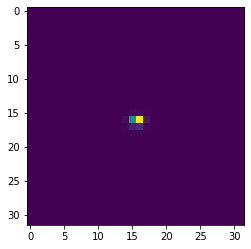

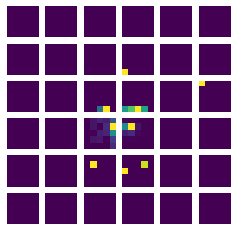

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[0,:,:,0]
plt.imshow(image.astype("float32"))
#plt.axis("off")#

patches = Patches(patch_size)(x_train[0:1,:,:,0:1])
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img.numpy().astype("float32"))
    plt.axis("off")

Implement the patch encoding layer<br>
<sub>The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.</sub>

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Build the ViT model<br>
<sub>The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

In [17]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
        

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)
    # Classify outputs.
    logits = layers.Dense(1)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Compile, train, and evaluate the mode

In [28]:
tf.keras.backend.clear_session()

In [29]:
def run_experiment(model):
    #optimizer = tfa.optimizers.AdamW(
       # learning_rate=learning_rate, weight_decay=weight_decay
    #)

    model.compile(
        #optimizer=optimizer,#keras.optimizers.Adam(lr=0.001),
        optimizer=keras.optimizers.Nadam(lr=0.001),
        loss= keras.losses.BinaryCrossentropy(from_logits=True),#'binary_crossentropy',
        #loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            'accuracy',
            'mae'
        ]
    )
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1.e-6)

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback,reduce_lr],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


Epoch 1/20
5603/5603 [==============================] - 265s 45ms/step - loss: 0.6318 - accuracy: 0.6124 - mae: 0.7433 - val_loss: 0.5877 - val_accuracy: 0.6900 - val_mae: 0.7609 - lr: 0.0010
Epoch 2/20
5603/5603 [==============================] - 249s 44ms/step - loss: 0.5884 - accuracy: 0.6790 - mae: 0.8547 - val_loss: 0.5703 - val_accuracy: 0.6996 - val_mae: 0.8395 - lr: 0.0010
Epoch 3/20
5603/5603 [==============================] - 249s 44ms/step - loss: 0.5800 - accuracy: 0.6886 - mae: 0.8803 - val_loss: 0.5639 - val_accuracy: 0.7050 - val_mae: 0.9529 - lr: 0.0010
Epoch 4/20
5603/5603 [==============================] - 248s 44ms/step - loss: 0.5746 - accuracy: 0.6925 - mae: 0.8997 - val_loss: 0.5580 - val_accuracy: 0.7023 - val_mae: 0.8693 - lr: 0.0010
Epoch 5/20
5603/5603 [==============================] - 248s 44ms/step - loss: 0.5715 - accuracy: 0.6962 - mae: 0.9115 - val_loss: 0.5707 - val_accuracy: 0.6877 - val_mae: 1.0802 - lr: 0.0010
Epoch 6/20
5603/5603 [==================

Calculate the ROC score 

In [30]:
from sklearn.metrics import roc_curve, auc
# Evaluate on test set
score = vit_classifier.evaluate(x_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = vit_classifier.predict(x_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

3113/3113 [==============================] - 38s 12ms/step - loss: 0.5609 - accuracy: 0.7229 - mae: 0.7314

Test loss / accuracy: 0.5609 / 0.7229
Test ROC AUC: 0.7956047026377298


ROC Curve Plot 

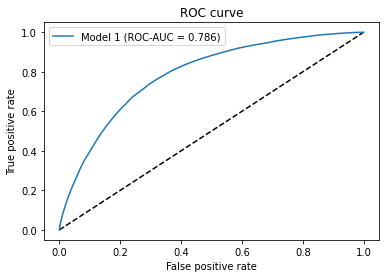

In [95]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

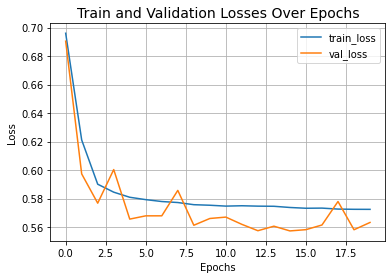

In [96]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


#Compact Convulational Transformer

In [54]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


170508288/170498071 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 10)


In [77]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 20
image_size = 32


In [78]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 1))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None


In [79]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


In [80]:
# MLP for the Transformer encoder
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [50]:
# Data agumentation
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [   layers.Normalization(),
        #layers.RandomCrop(image_size, image_size),
        #layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)


In [81]:
# Final CCT model
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [83]:
# Model training and evaluation
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            "accuracy"
            #keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.2,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


cct_model = create_cct_model()
history = run_experiment(cct_model)


Epoch 1/20
2490/2490 [==============================] - 63s 24ms/step - loss: 0.6129 - accuracy: 0.6418 - val_loss: 0.5754 - val_accuracy: 0.6846
Epoch 2/20
2490/2490 [==============================] - 60s 24ms/step - loss: 0.5818 - accuracy: 0.6847 - val_loss: 0.5798 - val_accuracy: 0.6798
Epoch 3/20
2490/2490 [==============================] - 60s 24ms/step - loss: 0.5730 - accuracy: 0.6936 - val_loss: 0.5726 - val_accuracy: 0.6924
Epoch 4/20
2490/2490 [==============================] - 60s 24ms/step - loss: 0.5688 - accuracy: 0.6971 - val_loss: 0.5677 - val_accuracy: 0.7130
Epoch 5/20
2490/2490 [==============================] - 60s 24ms/step - loss: 0.5663 - accuracy: 0.7003 - val_loss: 0.5601 - val_accuracy: 0.7116
Epoch 6/20
2490/2490 [==============================] - 60s 24ms/step - loss: 0.5633 - accuracy: 0.7022 - val_loss: 0.5554 - val_accuracy: 0.6877
Epoch 7/20
2490/2490 [==============================] - 60s 24ms/step - loss: 0.5630 - accuracy: 0.7028 - val_loss: 0.5482 -

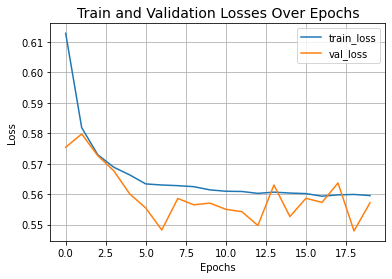

In [86]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


In [85]:
from sklearn.metrics import roc_curve, auc
# Evaluate on test set
score = cct_model.evaluate(x_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = cct_model.predict(x_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

3113/3113 [==============================] - 17s 6ms/step - loss: 0.5635 - accuracy: 0.7206

Test loss / accuracy: 0.5635 / 0.7206
Test ROC AUC: 0.7885367682039759


# Your turn, All the Best!